In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import re

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn import tree

from imblearn.over_sampling import RandomOverSampler

In [2]:
# to look at all columns of data
pd.options.display.max_columns = None

In [3]:
train_data = pd.read_csv('data/train.csv', index_col='studentId')
test_data = pd.read_csv('data/test.csv', index_col='studentId')
whole_data = pd.concat([train_data, test_data])
train_data.head()

,createdDate,updatedDate,isExpelled,expellingReason,courseCompleted,isTopPerformer,preferedMentorGithubId,readyFullTime,courseId,userId,mentorId,cvUrl,hiredById,hiredByName,isFailed,startDate,endDate,repository,repositoryLastActivityDate,idUser,educationHistory,englishLevel
studentId,,,,,,,,,,,,,,,,,,,,,,
5740,2019-09-06 17:30:17.681556,2019-12-03 16:24:58.705742,t,No activity in private repository,f,True,NaN,NaN,11,4467,647.0,NaN,NaN,NaN,f,2019-09-09 07:35:20.981+00,2019-12-04 09:17:02.998689+00,https://github.com/rolling-scopes-school/1b3f6...,NaN,4467,[],NaN
6956,2019-09-09 18:24:04.90096,2019-11-20 22:00:13.036321,t,No activity in private repository,f,True,NaN,NaN,11,5580,795.0,NaN,NaN,NaN,f,2019-09-09 07:35:20.981+00,2019-12-04 09:17:02.998689+00,https://github.com/rolling-scopes-school/76c0e...,NaN,5580,[],NaN
11616,2020-02-05 12:39:48.166948,2020-02-05 12:39:48.166948,f,NaN,f,False,NaN,NaN,16,9557,NaN,NaN,NaN,NaN,f,2020-02-05 12:39:48.164+00,NaN,NaN,NaN,9557,[],NaN
11773,2020-02-05 17:16:46.874484,2020-02-05 17:16:46.874484,f,NaN,f,False,NaN,NaN,16,9627,NaN,NaN,NaN,NaN,f,2020-02-05 17:16:46.872+00,NaN,NaN,NaN,9627,"[{""graduationYear"":null,""faculty"":null,""univer...",b1
6724,2019-09-09 17:06:56.967084,2020-01-19 16:55:12.069984,t,Failed Stage 2,f,True,NaN,NaN,11,5390,928.0,NaN,NaN,NaN,f,2019-09-09 07:35:20.981+00,1970-01-01 00:00:00+00,https://github.com/rolling-scopes-school/7fb23...,NaN,5390,[],NaN


check that this is same field (idUser and userId)

In [4]:
(~train_data['userId'] == train_data['idUser']).sum()

0

In [5]:
(~test_data['userId'] == test_data['idUser']).sum()

0

check that train and test have no intersection

In [6]:
train_data.join(test_data, rsuffix='_test', how='inner').shape

(0, 43)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10471 entries, 5740 to 12852
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   createdDate                 10471 non-null  object 
 1   updatedDate                 10471 non-null  object 
 2   isExpelled                  10471 non-null  object 
 3   expellingReason             5460 non-null   object 
 4   courseCompleted             10471 non-null  object 
 5   isTopPerformer              10471 non-null  bool   
 6   preferedMentorGithubId      0 non-null      float64
 7   readyFullTime               1 non-null      object 
 8   courseId                    10471 non-null  int64  
 9   userId                      10471 non-null  int64  
 10  mentorId                    2609 non-null   float64
 11  cvUrl                       0 non-null      float64
 12  hiredById                   0 non-null      float64
 13  hiredByName                 

In [8]:
pd.concat([train_data.isna().sum().rename('train_na_sum'), test_data.isna().sum().rename('test_na_sum')], axis=1)

,train_na_sum,test_na_sum
createdDate,0,0.0
updatedDate,0,0.0
isExpelled,0,0.0
expellingReason,5011,2991.0
courseCompleted,0,0.0
isTopPerformer,0,NaN
preferedMentorGithubId,10471,2991.0
readyFullTime,10470,2991.0
courseId,0,0.0
userId,0,0.0


In [9]:
def extract_englishlevel(data):
    rename_english_levels = \
                 {'elementary' : 'a1',
                  'intermidiate' : 'a1',
                  'pre-intermediate' : 'a2',
                  'pre-intermedia': 'a1',
                  'pre intermediate': 'a1', 
                  'intermediate' : 'b1',
                  'intermediate(b1)' : 'b1',
                  'upper-intermediate' : 'b2',
                  'up-intermediate' : 'b2',
                  'upper' : 'b2',
                  'advanced' : 'c1'}

    english_level = data['englishLevel'].str.strip().str.lower().str.split().str[0].replace(rename_english_levels)
    english_level = english_level.str.extract(r'(a0|a1|a2|b1|b2|c1|c2)\+?\-?/?~?')
    english_level.fillna('isna', inplace=True)
    return english_level

In [10]:
def get_size_of_course(whole_data):
    return whole_data.join(whole_data.groupby(by='courseId').size().rename('size_of_course'), on='courseId')['size_of_course']

In [11]:
def get_student_scores(whole_data, task_results_data):
    return whole_data.join(task_results_data.groupby(by='studentId')['score'].sum().rename('sum_of_scores'), on='studentId')['sum_of_scores'].fillna(0)

In [12]:
task_results_data = pd.read_csv('data/task_results.csv')
task_results_data.head()

,createdDate,updatedDate,score,comment,studentId,courseTaskId,historicalScores,juryScores,checkerId,anonymous
0,2019-09-19 18:36:46.232791,2019-09-19 18:36:46.232791,100,NaN,7266,300,"[{""authorId"":0,""score"":100,""dateTime"":15689182...",[],NaN,NaN
1,2019-10-02 12:48:27.977059,2019-10-21 09:58:59.674519,41,NaN,7929,313,"[{""authorId"":0,""score"":38,""dateTime"":157002050...",[],NaN,NaN
2,2019-10-08 15:05:43.777805,2019-10-08 15:05:43.777805,100,NaN,6134,308,"[{""authorId"":0,""score"":100,""dateTime"":15705471...",[],NaN,NaN
3,2019-10-11 15:03:28.245927,2019-10-11 15:03:28.245927,100,NaN,5882,305,"[{""authorId"":0,""score"":100,""dateTime"":15708062...",[],NaN,NaN
4,2019-10-12 16:31:57.699719,2019-10-12 16:31:57.699719,100,NaN,8247,305,"[{""authorId"":0,""score"":100,""dateTime"":15708979...",[],NaN,NaN


In [13]:
def get_jury_scores(whole_data, task_results_data):
    jury_df = pd.DataFrame(index=whole_data.index, columns=['sum_of_jury_scores'])
    
    jury_scores = task_results_data[(task_results_data['juryScores'] != '[]') & (~task_results_data['juryScores'].isna())]['juryScores']
    for it in jury_scores.iteritems():
        index = it[0]            
        scores_list = json.loads(it[1])
        sum_of_scores = 0
        for elem in scores_list:
            sum_of_scores += elem['score']
        jury_df.loc[index, 'sum_of_jury_scores'] = sum_of_scores

    return jury_df

In [14]:
jury_scores = get_jury_scores(whole_data, task_results_data)
jury_scores.dropna()

,sum_of_jury_scores
studentId,
18199,72
19134,81
19293,73
19409,96
19432,120
...,...
72741,284
72973,440
73052,253


In [15]:
joined_jury_scores = whole_data.join(jury_scores)['sum_of_jury_scores']
joined_jury_scores[~joined_jury_scores.isna()]

Series([], Name: sum_of_jury_scores, dtype: object)

If i am not mistaken - jury scores are useless, as there are no intersection with students id's

Let's try to calculate number of courses student have. If i understand correctly we can try to get this information from userId field

In [16]:
whole_data.groupby(by='userId').size()

userId
568      1
569      1
570      5
571      1
572      2
        ..
12483    1
12532    1
12544    1
17673    1
17704    1
Length: 9849, dtype: int64

For example one user with userId=574 probably took 4 courses with different studentId's (i may be wrong here, but in description of data there is no information. also in chat i didn't get the answer)

In [17]:
whole_data[whole_data.userId == 574]

,createdDate,updatedDate,isExpelled,expellingReason,courseCompleted,isTopPerformer,preferedMentorGithubId,readyFullTime,courseId,userId,mentorId,cvUrl,hiredById,hiredByName,isFailed,startDate,endDate,repository,repositoryLastActivityDate,idUser,educationHistory,englishLevel
studentId,,,,,,,,,,,,,,,,,,,,,,
14010,2020-03-23 09:40:30.661828,2020-07-01 21:33:02.558552,f,NaN,f,False,NaN,NaN,21,574,NaN,NaN,NaN,NaN,f,2020-03-23 09:40:30.659+00,NaN,NaN,NaN,574,"[{""graduationYear"":""2008"",""faculty"":""Managemen...",b2
601,2019-04-24 10:03:40.391388,2019-08-05 12:50:17.352095,f,NaN,f,True,NaN,NaN,2,574,174.0,NaN,NaN,NaN,f,2018-09-01 19:47:14.081+00,2018-12-31 19:47:14.081+00,NaN,NaN,574,"[{""graduationYear"":""2008"",""faculty"":""Managemen...",b2
5684,2019-08-29 14:19:17.984879,2019-08-30 07:25:11.378406,f,NaN,f,False,NaN,NaN,12,574,NaN,NaN,NaN,NaN,f,2019-04-08 07:23:45.643+00,2019-07-10 07:23:45.643+00,NaN,NaN,574,"[{""graduationYear"":""2008"",""faculty"":""Managemen...",b2
2085,2019-05-03 10:51:18.521518,2019-08-05 08:55:09.750177,f,NaN,f,NaN,NaN,NaN,1,574,NaN,NaN,NaN,NaN,f,2019-01-01 00:49:13.461+00,NaN,NaN,NaN,574,"[{""graduationYear"":""2008"",""faculty"":""Managemen...",b2


In [18]:
whole_data.join(whole_data.groupby(by='userId').size().rename('num_courses'), on='userId')['num_courses'].shape

(13462,)

In [19]:
train_data.shape[0] + test_data.shape[0]

13462

In [20]:
def get_education_features(data):
    education_df = pd.DataFrame(index=data.index, columns=['graduation_year']) #, 'faculty', 'university'])

    for it in data[data['educationHistory'] != '[]'].itertuples():
        edu_dict = json.loads(it.educationHistory)[0]
        index = it.Index
    
        if 'graduationYear' in edu_dict and edu_dict['graduationYear'] is not None:
            match = re.search(r'^(\d{4}).*', edu_dict['graduationYear'])
            if match is not None:
                education_df.loc[index, 'graduation_year'] = match.group(1)
            
#         if 'faculty' in edu_dict and edu_dict['faculty'] is not None:
#             education_df.loc[index, 'faculty'] = edu_dict['faculty']
        
#         if 'university' in edu_dict and edu_dict['university'] is not None:
#             education_df.loc[index, 'university'] = edu_dict['university']

    # TODO think about faculty and university later ?
            
    education_df['grad_group_year'] = pd.qcut(education_df['graduation_year'].astype(float), q=5, labels=['grad_year_' + str(i) for i in range(5)])
    return education_df['grad_group_year'].astype(str).fillna('grad_year_na')

In [21]:
def get_features(data):
    result = pd.DataFrame(index=data.index)
    
    result['english_level'] = extract_englishlevel(data)
    
    # maybe not best idea to use whole dataset knowledge, but in this case i think it's ok
    result['size_of_course'] = get_size_of_course(whole_data)
    result['num_courses_for_student'] = whole_data.join(whole_data.groupby(by='userId').size().rename('num_courses'), on='userId')['num_courses']

    result['sum_of_scores'] = get_student_scores(whole_data, task_results_data)    
    #result['sum_of_jury_scores'] = get_jury_scores(whole_data, task_results_data)
    
    result['invite_only_course'] = data.join(courses_data[['inviteOnly', 'courseId']].set_index('courseId'), on='courseId')['inviteOnly'].replace({'f':0,'t':1})
    result['num_tasks'] = data.join(task_results_data.groupby(by='studentId')['score'].size().rename('num_tasks'))['num_tasks'].fillna(0)
    
        
    result['repository_last_activity_na'] = data['repositoryLastActivityDate'].isna().astype(float)
    result['repository_na'] = data['repository'].isna().astype(float)
    
    result['has_mentor'] = (~data['mentorId'].isna()).astype(float)
    
#     users_mentors_joined = data.join(data.groupby(by='mentorId').size().rename('num_students'), on='userId')
#     users_mentors_joined['num_students'].fillna(0, inplace=True)
#   ##  result['num_students'] = users_mentors_joined['num_students']
    
    result['has_education_history'] = (data['educationHistory'] != '[]').astype(float)
    result['grad_year_group'] = get_education_features(data)
    
    timedelta_diff = pd.to_datetime(whole_data['updatedDate']) - pd.to_datetime(whole_data['createdDate'])
    days_diff = timedelta_diff.astype('timedelta64[D]')
    result['days_from_update'] = pd.qcut(days_diff, q=3, labels=['updated_days_' + str(i) for i in range(1, 4)])
    
    #result['course_id'] = whole_data['courseId'].astype(float)
    
    result = pd.get_dummies(result, columns=['english_level', 'grad_year_group', 'days_from_update'])
    #result = pd.get_dummies(result, columns=['days_from_update'])
    return result


def get_target(data):
    return data['isTopPerformer'].astype(float).values

In [22]:
train_data['isExpelled'].value_counts()

t    6769
f    3702
Name: isExpelled, dtype: int64

In [23]:
test_data['isExpelled'].value_counts()

f    2991
Name: isExpelled, dtype: int64

It's a bit confusing that all data in test has false value for isExpelled. Maybe i'll return to this feature later

In [24]:
test_data['expellingReason'].value_counts()

Series([], Name: expellingReason, dtype: int64)

expellingReason isNaN for all test data, so let's skip this column, as it can't be used for prediction

In [25]:
train_data['courseCompleted'].value_counts()

f    10471
Name: courseCompleted, dtype: int64

In [26]:
train_data['readyFullTime'].isna().sum()

10470

courseCompleted and readyFullTime are useless - they are constant

In [27]:
train_data['isFailed'].value_counts(dropna=False)

f    9036
t    1435
Name: isFailed, dtype: int64

In [28]:
test_data['isFailed'].value_counts(dropna=False)

f    2991
Name: isFailed, dtype: int64

Is failed is constant on test data as well, seems useless

In [29]:
train_data['preferedMentorGithubId'].isna().sum()

10471

preferedMentorGithubId is useless as well

In [30]:
pd.concat([train_data['courseId'].value_counts(dropna=False).sort_index().rename('train'),
           test_data['courseId'].value_counts(dropna=False).sort_index().rename('test')], axis=1)

,train,test
1,1591.0,254
2,1144.0,179
4,83.0,14
5,37.0,8
6,35.0,7
9,337.0,59
10,78.0,14
11,2669.0,454
12,18.0,3
13,2807.0,513


We see that test has courses that are not in train (28 and 29)

In [31]:
(~test_data['startDate'].isna()).sum()

2991

In [32]:
(~test_data['endDate'].isna()).sum()

0

We don't see endDate in test data so we can't use it

In [33]:
(~test_data['hiredById'].isna()).sum()

0

In [34]:
(~test_data['hiredByName'].isna()).sum()

0

In [35]:
(~test_data['repositoryLastActivityDate'].isna()).sum()

78

In [36]:
train_data[~train_data['repositoryLastActivityDate'].isna()]['isTopPerformer'].value_counts()

True     357
False     14
Name: isTopPerformer, dtype: int64

While looking at all NA values in test data, i found repositoryLastActivityDate, which is sometimes not zero. We see on train data that it's seems to be very cool feature. Let's use it as a boolean flag

In [37]:
(~test_data['repository'].isna()).sum()

287

In [38]:
train_data[~train_data['repository'].isna()]['isTopPerformer'].value_counts()

True     1301
False     209
Name: isTopPerformer, dtype: int64

presense of repository seems to be valuable similiar to repositoryLastActivityDate

In [39]:
(~test_data['cvUrl'].isna()).sum()

0

In [40]:
(~train_data['cvUrl'].isna()).sum()

0

cvUrl is always NA

In [41]:
(~test_data['mentorId'].isna()).sum()

467

In [42]:
train_data[~train_data['mentorId'].isna()]['isTopPerformer'].value_counts()

True     1862
False     747
Name: isTopPerformer, dtype: int64

Let's add feature - how many students has mentor. For this let's group by mentorId and join it on userId from original data<br/>
Below test area, actual feature calculation is in function get_features

In [43]:
test = train_data.join(train_data.groupby(by='mentorId').size().rename('num_students'), on='userId')
test['num_students'].fillna(0, inplace=True)
test[test['num_students'] > 0].tail()

,createdDate,updatedDate,isExpelled,expellingReason,courseCompleted,isTopPerformer,preferedMentorGithubId,readyFullTime,courseId,userId,mentorId,cvUrl,hiredById,hiredByName,isFailed,startDate,endDate,repository,repositoryLastActivityDate,idUser,educationHistory,englishLevel,num_students
studentId,,,,,,,,,,,,,,,,,,,,,,,
11873,2020-02-05 21:52:08.293923,2020-08-23 20:27:10.960391,t,no completed tasks,f,False,NaN,NaN,13,1109,NaN,NaN,NaN,NaN,f,2020-02-05 21:52:08.291+00,2020-04-14 17:34:16.479+00,NaN,NaN,1109,"[{""graduationYear"":""2018"",""faculty"":""Informati...",a2,1.0
12266,2020-02-09 21:22:30.333915,2020-08-23 20:27:10.960391,t,no completed tasks,f,False,NaN,NaN,13,662,NaN,NaN,NaN,NaN,f,2020-02-09 21:22:30.331+00,2020-04-14 17:34:16.479+00,NaN,NaN,662,"[{""graduationYear"":"""",""faculty"":""FIT"",""univers...",a2,2.0
10834,2020-02-03 13:51:25.347884,2020-08-23 20:27:10.960391,t,no completed tasks,f,False,NaN,NaN,13,1192,NaN,NaN,NaN,NaN,f,2020-02-03 13:51:25.345+00,2020-04-14 17:34:16.479+00,NaN,NaN,1192,"[{""graduationYear"":""2006"",""faculty"":""Instrumen...",A2,2.0
10006,2020-02-02 10:16:09.942336,2020-08-23 20:27:10.960391,t,no completed tasks,f,False,NaN,NaN,13,978,NaN,NaN,NaN,NaN,f,2020-02-02 10:16:09.94+00,2020-04-14 17:34:16.479+00,NaN,NaN,978,"[{""graduationYear"":null,""faculty"":""Information...",a2,5.0
12916,2020-02-17 17:13:17.335724,2020-10-13 21:00:01.563666,t,Course score is too low,f,False,NaN,NaN,19,1241,NaN,NaN,NaN,NaN,f,2020-02-17 17:13:17.333+00,2020-05-28 13:54:20.092+00,NaN,NaN,1241,"[{""graduationYear"":""2014"",""faculty"":""Commerce ...",b2,1.0


In [44]:
education_df = pd.DataFrame(index=test_data.index, columns=['graduation_year', 'faculty', 'university'])

for it in test_data[test_data['educationHistory'] != '[]'].itertuples():
    edu_dict = json.loads(it.educationHistory)[0]
    index = it.Index
    
    if 'graduationYear' in edu_dict and edu_dict['graduationYear'] is not None:
        match = re.search(r'^(\d{4}).*', edu_dict['graduationYear'])
        if match is not None:
            education_df.loc[index, 'graduation_year'] = match.group(1)
            
    if 'faculty' in edu_dict and edu_dict['faculty'] is not None:
        education_df.loc[index, 'faculty'] = edu_dict['faculty']
        
    if 'university' in edu_dict and edu_dict['university'] is not None:
        education_df.loc[index, 'university'] = edu_dict['university']

education_df[~education_df.university.isna()].head()

,graduation_year,faculty,university
studentId,,,
6958,2006,Physico-Technical Faculty,Yanka Kupala State University of Grodno
8004,2006,Physics and Technology Faculty,Yanka Kupala State University of Grodno
9155,2012,Mechanical Engineering,Belarusian National Technical University
6613,2010,Faculty of Telecommunications,BSUIR
5979,2012,Business-administration,Brest State University named after A.S.Pushkin


In [45]:
diff = pd.to_datetime(test_data['updatedDate']) - pd.to_datetime(test_data['createdDate'])
days = diff.astype('timedelta64[D]')
days

studentId
11450     56.0
7855      70.0
12753    239.0
14717     73.0
7455     132.0
         ...  
13278    238.0
14984     78.0
14557     97.0
15249     78.0
15012     78.0
Length: 2991, dtype: float64

In [46]:
pd.qcut(days, q=5, labels=['updated_days_' + str(i) for i in range(1, 6)])

studentId
11450    updated_days_2
7855     updated_days_2
12753    updated_days_5
14717    updated_days_2
7455     updated_days_4
              ...      
13278    updated_days_5
14984    updated_days_3
14557    updated_days_4
15249    updated_days_3
15012    updated_days_3
Length: 2991, dtype: category
Categories (5, object): ['updated_days_1' < 'updated_days_2' < 'updated_days_3' < 'updated_days_4' < 'updated_days_5']

In [47]:
train_data.drop(columns=['isFailed',
                         'preferedMentorGithubId',
                         'readyFullTime',
                         'isExpelled',
                         'expellingReason',
                         'courseCompleted',
                         'englishLevel',
                         'startDate',
                         'endDate',
                         'hiredById',
                         'hiredByName',
                         'repositoryLastActivityDate',
                         'repository',
                         'cvUrl',
                         'mentorId',
                         'idUser',
                         'userId',
                         'educationHistory',
                         'createdDate',
                         'updatedDate'])

,isTopPerformer,courseId
studentId,,
5740,True,11
6956,True,11
11616,False,16
11773,False,16
6724,True,11
...,...,...
13213,True,19
12819,False,19
12707,False,19


Idea to calculate size of a course

In [48]:
train_data.join(pd.concat([train_data, test_data]).groupby(by='courseId').size().rename('size_of_course'), on='courseId').head()

,createdDate,updatedDate,isExpelled,expellingReason,courseCompleted,isTopPerformer,preferedMentorGithubId,readyFullTime,courseId,userId,mentorId,cvUrl,hiredById,hiredByName,isFailed,startDate,endDate,repository,repositoryLastActivityDate,idUser,educationHistory,englishLevel,size_of_course
studentId,,,,,,,,,,,,,,,,,,,,,,,
5740,2019-09-06 17:30:17.681556,2019-12-03 16:24:58.705742,t,No activity in private repository,f,True,NaN,NaN,11,4467,647.0,NaN,NaN,NaN,f,2019-09-09 07:35:20.981+00,2019-12-04 09:17:02.998689+00,https://github.com/rolling-scopes-school/1b3f6...,NaN,4467,[],NaN,3123
6956,2019-09-09 18:24:04.90096,2019-11-20 22:00:13.036321,t,No activity in private repository,f,True,NaN,NaN,11,5580,795.0,NaN,NaN,NaN,f,2019-09-09 07:35:20.981+00,2019-12-04 09:17:02.998689+00,https://github.com/rolling-scopes-school/76c0e...,NaN,5580,[],NaN,3123
11616,2020-02-05 12:39:48.166948,2020-02-05 12:39:48.166948,f,NaN,f,False,NaN,NaN,16,9557,NaN,NaN,NaN,NaN,f,2020-02-05 12:39:48.164+00,NaN,NaN,NaN,9557,[],NaN,421
11773,2020-02-05 17:16:46.874484,2020-02-05 17:16:46.874484,f,NaN,f,False,NaN,NaN,16,9627,NaN,NaN,NaN,NaN,f,2020-02-05 17:16:46.872+00,NaN,NaN,NaN,9627,"[{""graduationYear"":null,""faculty"":null,""univer...",b1,421
6724,2019-09-09 17:06:56.967084,2020-01-19 16:55:12.069984,t,Failed Stage 2,f,True,NaN,NaN,11,5390,928.0,NaN,NaN,NaN,f,2019-09-09 07:35:20.981+00,1970-01-01 00:00:00+00,https://github.com/rolling-scopes-school/7fb23...,NaN,5390,[],NaN,3123


In [49]:
train_data['englishLevel'].value_counts(dropna=False).head(20)

NaN                 5059
a2                  1629
b1                  1141
a1                   957
b2                   442
a0                   224
A2                   140
a2+                  131
B1                   119
c1                   101
B2                    70
b1+                   57
a1+                   46
b2+                   36
Intermediate          30
A1                    29
C1                    28
A2+                   27
c2                    18
Pre-Intermediate      12
Name: englishLevel, dtype: int64

In [50]:
courses_data = pd.read_csv('data/course.csv')
courses_data.head(3)

,courseId,createdDate,updatedDate,name,year,primarySkillId,primarySkillName,locationName,alias,completed,description,descriptionUrl,planned,courseStartDate,courseEndDate,fullName,registrationEndDate,inviteOnly
0,16,2020-01-27 06:15:21.813898,2020-06-02 09:49:08.084615,RSS React 2020,NaN,javascript,JavaScript,NaN,react-2020-Q1,t,Курс по React/Redux,NaN,f,2020-02-05 06:12:15.345+00,2020-03-18 06:12:18.391+00,RSS React 2020,2020-02-09 06:12:31.757+00,t
1,23,2020-02-25 09:28:08.842897,2020-07-28 06:07:15.142387,TEST COURSE,NaN,javascript,JavaScript,NaN,test-course,f,TEST COURSE,NaN,f,2020-02-25 09:28:00.105+00,2020-08-06 09:28:01.698+00,TEST COURSE,NaN,t
2,18,2020-02-11 08:40:16.050523,2020-09-10 18:30:58.028305,iOS 2020,NaN,ios-obj-c,iOS Objective-C,NaN,ios-2020,f,iOS 2020 course,NaN,f,2020-02-17 08:39:56.164+00,2020-06-01 08:40:00.109+00,Rolling Scopes iOS 2020,2020-03-08 09:33:55.611+00,f


In [51]:
courses_data['inviteOnly'].value_counts(dropna=False)

f    13
t     8
Name: inviteOnly, dtype: int64

In [52]:
invite_only_course = train_data.join(courses_data[['inviteOnly', 'courseId']].set_index('courseId'), on='courseId')['inviteOnly'].replace({'f':0,'t':1})
invite_only_course.head()

studentId
5740     0
6956     0
11616    1
11773    1
6724     0
Name: inviteOnly, dtype: int64

In [53]:
task_data = pd.read_csv('data/task.csv', index_col='taskId')
task_data.head(2)

,createdDate,updatedDate,name,descriptionUrl,description,verification,githubPrRequired,useJury,allowStudentArtefacts,githubRepoName,sourceGithubRepoUrl,type,tags,discipline,attributes,courseTaskId,createdDateCourseTask,updatedDateCourseTask,mentorStartDate,mentorEndDate,maxScore,stageId,scoreWeight,checker,taskOwnerId,studentStartDate,studentEndDate,courseId,pairsCount,typeCourseTask,disabled,createdDateCourse,updatedDateCourse,nameCourse,year,primarySkillId,primarySkillName,locationName,alias,completed,descriptionCourse,descriptionUrlCourse,planned,courseStartDate,courseEndDate,fullName,registrationEndDate,inviteOnly
taskId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
413,2019-08-29 10:57:34.732592,2019-11-11 18:19:01.013044,ST JS Test,http://learn.javascript.ru/,NaN,manual,f,f,f,NaN,NaN,test,NaN,NaN,{},296,2019-08-29 11:01:40.171488,2019-08-29 13:11:10.876319,NaN,NaN,40.0,16.0,1.0,mentor,NaN,2019-04-10 00:00:00+00,2019-04-10 00:00:00+00,12,NaN,NaN,f,2019-08-29 07:26:02.025829,2019-10-25 17:20:30.9813,RS-ST 2019 Q1,NaN,javascript,JavaScript,NaN,rs-st-2019-q1,t,RS Short Track 2019 Q1,NaN,f,2019-04-08 07:23:45.643+00,2019-07-10 07:23:45.643+00,Rolling Scopes School 2019 Q1: Short Track,NaN,t
253,2019-05-17 13:02:30.233767,2019-05-17 13:02:30.233767,tdd,NaN,NaN,manual,NaN,f,f,NaN,NaN,NaN,NaN,NaN,{},292,2019-08-29 10:30:11.446774,2019-08-29 13:09:13.674882,NaN,NaN,100.0,16.0,1.0,mentor,NaN,2019-05-24 00:00:00+00,2019-05-24 00:00:00+00,12,NaN,NaN,f,2019-08-29 07:26:02.025829,2019-10-25 17:20:30.9813,RS-ST 2019 Q1,NaN,javascript,JavaScript,NaN,rs-st-2019-q1,t,RS Short Track 2019 Q1,NaN,f,2019-04-08 07:23:45.643+00,2019-07-10 07:23:45.643+00,Rolling Scopes School 2019 Q1: Short Track,NaN,t


Sum of student scores

In [54]:
task_results_data.groupby(by='studentId')['score'].sum()

studentId
1        1544
2         590
3           0
4         255
5           8
         ... 
15671     835
15691    1127
15730     220
15911     805
20893      60
Name: score, Length: 8430, dtype: int64

In [55]:
task_results_data['juryScores'].value_counts().head(3)

[]                                                                                                                                                                                                                                                                                                                               70257
[{"authorId":1202,"score":30,"dateTime":1576780831787,"comment":"Not very good English, confidant on the stage, reading from the paper 100% of the presentation. good answers on the questions."},{"authorId":677,"score":38,"dateTime":1576836448474,"comment":"nice pronunciation, but mostly reading instead of talking"}]        1
[{"authorId":4152,"score":120,"dateTime":1565417111765,"comment":""}]                                                                                                                                                                                                                                                                1
Name: juryScores, d

In [56]:
num_tasks = train_data.join(task_results_data.groupby(by='studentId')['score'].size().rename('num_tasks'))['num_tasks'].fillna(0)
num_tasks

studentId
5740     20.0
6956     17.0
11616     0.0
11773     0.0
6724     26.0
         ... 
13213    10.0
12819     0.0
12707     0.0
12863     1.0
12852     1.0
Name: num_tasks, Length: 10471, dtype: float64

In [57]:
features_train = get_features(train_data)
features_test = get_features(test_data)
features_train

,size_of_course,num_courses_for_student,sum_of_scores,invite_only_course,num_tasks,repository_last_activity_na,repository_na,has_mentor,has_education_history,english_level_a0,english_level_a1,english_level_a2,english_level_b1,english_level_b2,english_level_c1,english_level_c2,english_level_isna,grad_year_group_grad_year_0,grad_year_group_grad_year_1,grad_year_group_grad_year_2,grad_year_group_grad_year_3,grad_year_group_grad_year_4,grad_year_group_grad_year_na,days_from_update_updated_days_1,days_from_update_updated_days_2,days_from_update_updated_days_3
studentId,,,,,,,,,,,,,,,,,,,,,,,,,,
5740,3123,1,1646.0,0,20.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
6956,3123,1,1482.0,0,17.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
11616,421,1,0.0,1,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
11773,421,1,0.0,1,0.0,1.0,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
6724,3123,5,2015.0,0,26.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13213,388,1,3100.0,0,10.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
12819,388,1,0.0,0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
12707,388,2,0.0,0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [58]:
features_test['num_courses_for_student'].sort_values(ascending=False)

studentId
12914    10
15107    10
15106    10
15321     7
9204      7
         ..
890       1
5282      1
6937      1
13365     1
15012     1
Name: num_courses_for_student, Length: 2991, dtype: int64

In [59]:
for column in features_test.columns:
    print(column)
    print(features_test[column].value_counts())

size_of_course
896     896
3320    513
3123    454
1845    254
245     245
1323    179
421      76
388      70
455      68
396      59
317      59
208      36
139      24
92       14
97       14
45        8
62        8
42        7
24        3
21        3
3         1
Name: size_of_course, dtype: int64
num_courses_for_student
1     1392
2      796
3      459
4      179
5       94
6       38
7       30
10       3
Name: num_courses_for_student, dtype: int64
sum_of_scores
0.0       1767
100.0       57
1224.0      24
50.0        18
300.0       16
          ... 
361.0        1
164.0        1
879.0        1
197.0        1
1174.0       1
Name: sum_of_scores, Length: 835, dtype: int64
invite_only_course
0    2772
1     219
Name: invite_only_course, dtype: int64
num_tasks
0.0     1557
1.0      313
6.0      209
5.0      171
2.0      141
        ... 
65.0       1
41.0       1
60.0       1
45.0       1
48.0       1
Name: num_tasks, Length: 64, dtype: int64
repository_last_activity_na
1.0    2913
0.0

In [60]:
train_data['isTopPerformer'].value_counts()

False    7892
True     2579
Name: isTopPerformer, dtype: int64

In [61]:
y = get_target(train_data)
y.shape

(10471,)

In [62]:
features_train.columns

Index(['size_of_course', 'num_courses_for_student', 'sum_of_scores',
       'invite_only_course', 'num_tasks', 'repository_last_activity_na',
       'repository_na', 'has_mentor', 'has_education_history',
       'english_level_a0', 'english_level_a1', 'english_level_a2',
       'english_level_b1', 'english_level_b2', 'english_level_c1',
       'english_level_c2', 'english_level_isna', 'grad_year_group_grad_year_0',
       'grad_year_group_grad_year_1', 'grad_year_group_grad_year_2',
       'grad_year_group_grad_year_3', 'grad_year_group_grad_year_4',
       'grad_year_group_grad_year_na', 'days_from_update_updated_days_1',
       'days_from_update_updated_days_2', 'days_from_update_updated_days_3'],
      dtype='object')

In [63]:
# grid = sns.pairplot(pd.concat([features_train[['size_of_course', 'num_courses_for_student']], train_data['isTopPerformer'].astype(float)], axis=1), hue='isTopPerformer')
# grid.fig.set_size_inches(12, 6)

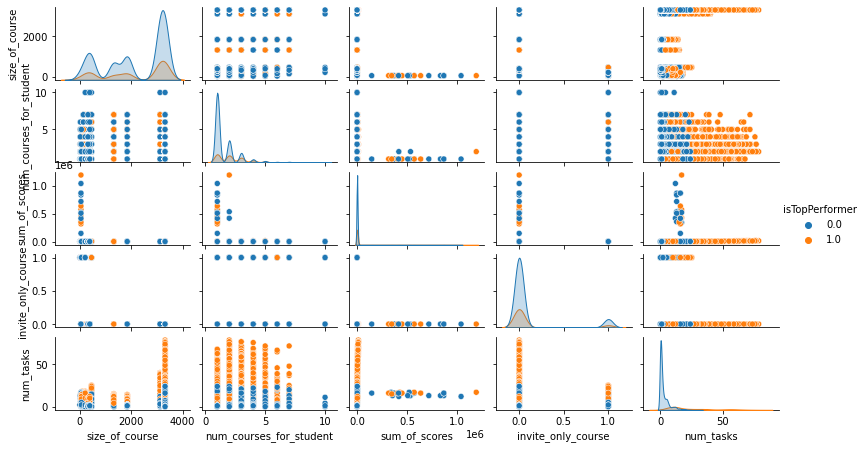

In [64]:
grid = sns.pairplot(pd.concat([features_train[features_train.columns[:5]], train_data['isTopPerformer'].astype(float)], axis=1), hue='isTopPerformer')
grid.fig.set_size_inches(12, 6)

In [65]:
# grid = sns.pairplot(pd.concat([features_train[features_train.columns[5:11]], train_data['isTopPerformer'].astype(float)], axis=1), hue='isTopPerformer')
# grid.fig.set_size_inches(12, 6)

In [66]:
# grid = sns.pairplot(pd.concat([features_train[features_train.columns[11:16]], train_data['isTopPerformer'].astype(float)], axis=1), hue='isTopPerformer')
# grid.fig.set_size_inches(12, 6)

In [67]:
X = features_train.values
X_test_final = features_test.values
X.shape

(10471, 26)

In [68]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train.shape + X_val.shape

ros = RandomOverSampler(random_state=111)
X_resampled, y_resampled = ros.fit_resample(X, y)


# let's use train_test_split twice - first 0.4 of original dataset to test+val, then half of test to validation part
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=124)

X_train_and_test = np.vstack((X_train, X_test))
y_train_and_test = np.hstack((y_train, y_test))

X_train.shape + X_test.shape + X_val.shape

(9470, 26, 3157, 26, 3157, 26)

In [69]:

#X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.4)
#X_train.shape + X_val.shape

In [70]:
# f1_scores_train = []
# f1_scores_test = []
# oob_scores = []

# #X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_train, y_train, test_size=0.3)

# for n_trees in range(35, 101):
#     model = RandomForestClassifier(n_estimators = n_trees, oob_score=True, class_weight='balanced', ccp_alpha=0.01)
#     model.fit(X_train, y_train)
#     f1_scores_train.append(f1_score(y_train, model.predict(X_train)))
#     f1_scores_test.append(f1_score(y_test, model.predict(X_test)))
#     oob_scores.append(model.oob_score_)

In [71]:
# fig, ax = plt.subplots(figsize=(8, 4))
# plt.plot(range(35, 101), f1_scores_train, color='red', label='f1 score train')
# plt.plot(range(35, 101), f1_scores_test, color='blue', label='f1 score test')
# plt.plot(range(35, 101), oob_scores, color='green', label='oob score');
# plt.legend()
# plt.title('Score from num trees')

In [72]:
# f1_scores_train = []
# f1_scores_test = []
# oob_scores = []

# # let's fix num of trees equal to 100
# for depth in range(1, 31):
#     model = RandomForestClassifier(n_estimators = 100, max_depth=depth, oob_score=True, class_weight='balanced', ccp_alpha=0.01)
#     model.fit(X_train, y_train)
#     f1_scores_train.append(f1_score(y_train, model.predict(X_train)))
#     f1_scores_test.append(f1_score(y_test, model.predict(X_test)))
#     oob_scores.append(model.oob_score_)

In [73]:
# fig, ax = plt.subplots(figsize=(8, 4))
# plt.plot(range(1, 31), f1_scores_train, color='red', label='f1 score train')
# plt.plot(range(1, 31), f1_scores_test, color='blue', label='f1 score test')
# plt.plot(range(1, 31), oob_scores, color='green', label='oob score')
# plt.legend()
# plt.title('Score from max depth')

In [74]:
# # let's limit depth to 5 and repeat seach for num of trees

# f1_scores_train = []
# f1_scores_test = []
# oob_scores = []

# for features in range(1, X_train.shape[1] + 1):
#     model = RandomForestClassifier(n_estimators = 100, max_depth = 5, max_features = features, class_weight='balanced', ccp_alpha=0.01, oob_score=True)
#     model.fit(X_train, y_train)
#     f1_scores_train.append(f1_score(y_train, model.predict(X_train)))
#     f1_scores_test.append(f1_score(y_test, model.predict(X_test)))
#     oob_scores.append(model.oob_score_)

In [75]:
# fig, ax = plt.subplots(figsize=(8, 4))
# plt.plot(range(1, X_train.shape[1] + 1), f1_scores_train, color='red', label='f1 score train')
# plt.plot(range(1, X_train.shape[1] + 1), f1_scores_test, color='blue', label='f1 score test')
# plt.plot(range(1, X_train.shape[1] + 1), oob_scores, color='green', label='oob score')
# plt.legend()
# plt.title('Score from max features')

In [76]:
# f1_scores_train = []
# f1_scores_test = []
# oob_scores = []

# for ccp in np.linspace(0.0001, 0.01, 100):
#     model = RandomForestClassifier(n_estimators = 100, max_depth = 5, max_features = 5, class_weight='balanced', ccp_alpha=ccp, oob_score=True)
#     model.fit(X_train, y_train)
#     f1_scores_train.append(f1_score(y_train, model.predict(X_train)))
#     f1_scores_test.append(f1_score(y_test, model.predict(X_test)))
#     oob_scores.append(model.oob_score_)

In [77]:
# fig, ax = plt.subplots(figsize=(8, 4))
# plt.plot(np.linspace(0.0001, 0.01, 100), f1_scores_train, color='red', label='f1 score train')
# plt.plot(np.linspace(0.0001, 0.01, 100), f1_scores_test, color='blue', label='f1 score test')
# plt.plot(np.linspace(0.0001, 0.01, 100), oob_scores, color='green', label='oob score')
# plt.legend()
# plt.title('Score from ccp_alpha')

In [78]:
# let's fix ccp_alpha = 0.01

In [79]:
# final_model = RandomForestClassifier(n_estimators = 100, max_depth = 5, max_features = 5, class_weight='balanced', ccp_alpha=0.01, oob_score=True, random_state=42)
# final_model.fit(X_train_and_test, y_train_and_test)

# y_pred_train_and_test = final_model.predict(X_train_and_test)
# y_pred_val = final_model.predict(X_val)

# print(f1_score(y_train_and_test, y_pred_train_and_test))
# print(f1_score(y_val, y_pred_val))
# print(final_model.oob_score_)

In [80]:
# y_pred_train = final_model.predict(X_train)
# y_pred_test = final_model.predict(X_test)
# y_pred_val = final_model.predict(X_val)

In [81]:
# print(np.unique(y_pred_train, return_counts=True))
# print(np.unique(y_pred_test, return_counts=True))
# print(np.unique(y_pred_val, return_counts=True))

In [82]:
# # completely all data
# final_model = RandomForestClassifier(n_estimators = 100, max_depth = 5, max_features = 5, class_weight='balanced', ccp_alpha=0.01, oob_score=True, random_state=42)
# final_model.fit(X, y)

# y_pred = final_model.predict(X)

# print(f1_score(y, y_pred))
# print(final_model.oob_score_)
# print(np.unique(y_pred, return_counts=True))

In [149]:
rf_grid_params = dict(clf__n_estimators=np.arange(1, 201, 1),
                      clf__criterion=['entropy', 'gini'],
                      clf__max_features=['auto', 'sqrt', 'log2'],
                      clf__max_depth=list(np.arange(1, 10)),
                      clf__ccp_alpha=np.linspace(0.001, 0.1, 100))

knn_grid_params = dict(clf__n_neighbors=np.arange(1, 21, 1))

logreg_grid_params = dict(clf__penalty=['l1', 'l2'],
                          clf__C=np.linspace(0.01, 2, 100))

#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

rf_model = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=9, criterion='gini', ccp_alpha=0.002)
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression()

pipeline = Pipeline([('poly', PolynomialFeatures(interaction_only=True, degree=3)),
                     ('scaler', StandardScaler()),
                     ('select', SelectFromModel(rf_model)),
                     ('clf', logreg_model)])

model_search = RandomizedSearchCV(pipeline, logreg_grid_params, scoring='f1', n_iter=50, n_jobs=-1, refit=True, cv=5)
model_search.fit(X_train_and_test, y_train_and_test)


# y_pred_train = model_search.predict(X_train)
y_pred_val = model_search.predict(X_val)
# y_pred_test = model_search.predict(X_test)

C:\Users\Mi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.95669098 0.95751584 0.95711466
 0.95823608 0.95794425        nan 0.95771339        nan        nan
 0.95607284 0.95859475 0.95846346 0.96070639        nan 0.95501271
        nan        nan        nan        nan        nan        nan
        nan 0.95856823        nan 0.95853917 0.95050457        nan
 0.95906037 0.95833027        nan        nan 0.95852139        nan
 0.95257284        nan        nan 0.95579914        nan        nan
        nan 0.95803382        nan 0.95433789 0.94694887 0.9588917
 0.95843577 0.95793269]
  warnings.warn(
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.o

In [150]:
model_search.best_params_

{'clf__penalty': 'l2', 'clf__C': 1.778888888888889}

In [151]:
# f1_score(y_train, y_pred_train)

In [152]:
f1_score(y_val, y_pred_val)

0.9576753000631711

In [153]:
# y_pred_train = final_model.predict(X_train)
# y_pred_test = final_model.predict(X_test)
# y_pred_val = final_model.predict(X_val)

In [154]:
# np.unique(y_pred, return_counts=True)

In [155]:
# np.unique(y_pred_val, return_counts=True)

In [156]:
# np.unique(y_pred_test, return_counts=True)

In [157]:
# def plot_one_tree(model):
#     fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (50, 30))
#     tree.plot_tree(model,
#                feature_names = features_train.columns, 
#                class_names=['0', '1'],
#                filled = True);

# plot_one_tree(model_search.best_estimator_['clf'][0])

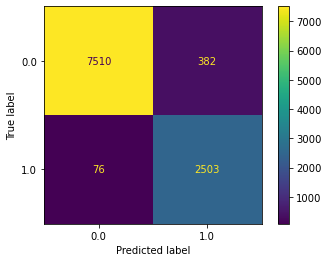

In [158]:
plot_confusion_matrix(model_search.best_estimator_, X, y)

In [159]:
#features_train.columns[model_search.best_estimator_['select'].get_support()]

In [160]:
y_test_final = model_search.best_estimator_.predict(X_test_final)
pd.DataFrame(data=y_test_final.astype(bool), index=test_data.index, columns=['isTopPerformer']).to_csv('final_rss_30.csv')

In [161]:
np.unique(y_test_final, return_counts=True)

(array([0., 1.]), array([2482,  509], dtype=int64))